In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

from skimage import measure, morphology, filters, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
%matplotlib inline

In [5]:
# Some constants 
INPUT_FOLDER = './input/'
SAMPLES_FOLDER = INPUT_FOLDER + 'sample_images/'
patients = os.listdir(SAMPLES_FOLDER)
patients.sort()

print(patients)

labels = pd.read_csv(INPUT_FOLDER + '/stage1_labels.csv')
labels.info()
labels.cancer.value_counts()

pid1 = '0acbebb8d463b4b9ca88cf38431aac69'
pid2 = '0d06d764d3c07572074d468b4cff954f'

['.DS_Store', '00cba091fa4ad62cc3200a657aeb957e', '0a099f2549429d29b32f349e95fb2244', '0a0c32c9e08cc2ea76a71649de56be6d', '0a38e7597ca26f9374f8ea2770ba870d', '0acbebb8d463b4b9ca88cf38431aac69', '0b20184e0cd497028bdd155d9fb42dc9', '0bd0e3056cbf23a1cb7f0f0b18446068', '0c0de3749d4fe175b7a5098b060982a1', '0c37613214faddf8701ca41e6d43f56e', '0c59313f52304e25d5a7dcf9877633b1', '0c60f4b87afcb3e2dfa65abbbf3ef2f9', '0c98fcb55e3f36d0c2b6507f62f4c5f1', '0c9d8314f9c69840e25febabb1229fa4', '0ca943d821204ceb089510f836a367fd', '0d06d764d3c07572074d468b4cff954f', '0d19f1c627df49eb223771c28548350e', '0d2fcf787026fece4e57be167d079383', '0d941a3ad6c889ac451caf89c46cb92a', '0ddeb08e9c97227853422bd71a2a695e', '0de72529c30fe642bc60dcb75c87f6bd']


FileNotFoundError: File b'./input//stage1_labels.csv' does not exist

# Helpers

In [115]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    return slices

# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    # image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    # p = image
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [103]:
# patient = load_scan(SAMPLES_FOLDER + pid1)
patient = get_3d_data(SAMPLES_FOLDER + pid1)
slices = get_pixels_hu(patient)
print(slices.shape)
print(patient[0])

(203, 512, 512)
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.303642909119486713425375993752
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '0acbebb8d463b4b9ca88cf38431aac69'
(0010, 0020) Patient ID                          LO: '0acbebb8d463b4b9ca88cf38431aac69'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.66234994940093060530875882673593880723182397297085825139120
(0020, 000e) Series Instance UID                 UI: 2.25.27985737130106072918310533525688877208529713445697698517643
(0020, 0011) Series Number                       IS: '4'
(0020, 0012) Acquisiti

[z, y, x] shape: (203, 512, 512)


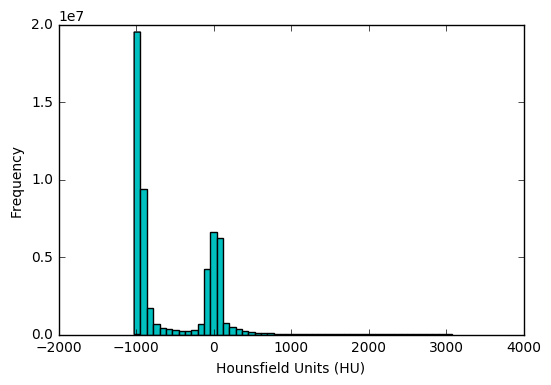

In [114]:
print("[z, y, x] shape: " + str(slices.shape))

plt.hist(slices.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


## Hounsfield density distribution

* https://en.wikipedia.org/wiki/Hounsfield_scale

<table class="wikitable">
<tbody><tr>
<th>Substance</th>
<th>HU</th>
</tr>
<tr>
<td><a href="/wiki/Air" class="mw-redirect" title="Air">Air</a></td>
<td>−1000</td>
</tr>
<tr>
<td><a href="/wiki/Lung" title="Lung">Lung</a></td>
<td>−500</td>
</tr>
<tr>
<td><a href="/wiki/Fat" title="Fat">Fat</a></td>
<td>−100 to −50</td>
</tr>
<tr>
<td><a href="/wiki/Water" title="Water">Water</a></td>
<td>0</td>
</tr>
<tr>
<td><a href="/wiki/Cerebrospinal_fluid" title="Cerebrospinal fluid">CSF</a></td>
<td>+15</td>
</tr>
<tr>
<td><a href="/wiki/Kidney" title="Kidney">Kidney</a></td>
<td>+30</td>
</tr>
<tr>
<td><a href="/wiki/Blood" title="Blood">Blood</a></td>
<td>+30 to +45</td>
</tr>
<tr>
<td><a href="/wiki/Muscle" title="Muscle">Muscle</a></td>
<td>+10 to +40</td>
</tr>
<tr>
<td>Grey matter</td>
<td>+37 to +45</td>
</tr>
<tr>
<td>White matter</td>
<td>+20 to +30</td>
</tr>
<tr>
<td><a href="/wiki/Liver" title="Liver">Liver</a></td>
<td>+40 to +60</td>
</tr>
<tr>
<td>Soft Tissue, Contrast</td>
<td>+100 to +300</td>
</tr>
<tr>
<td><a href="/wiki/Bone" title="Bone">Bone</a></td>
<td>+700 (cancellous bone) to +3000 (cortical bone)</td>
</tr>

</tbody></table>

In [134]:
patient = get_3d_data(SAMPLES_FOLDER + pid2)
slices = get_pixels_hu(patient)


(512, 512)


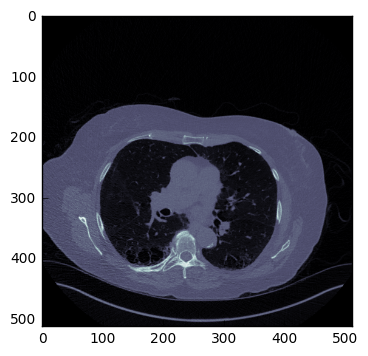

In [169]:
slice = slices[250, :, :]
print(slice.shape)
plt.imshow(slice, cmap=plt.cm.bone)

(435, 512)


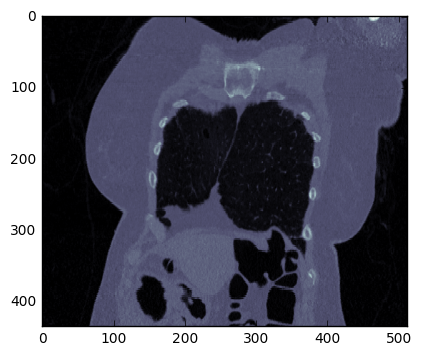

In [166]:
slice = slices[:,220,:]
print(slice.shape)
slice = transform.rotate(slice, 180)
plt.imshow(slice, cmap=plt.cm.bone)

(435, 512)


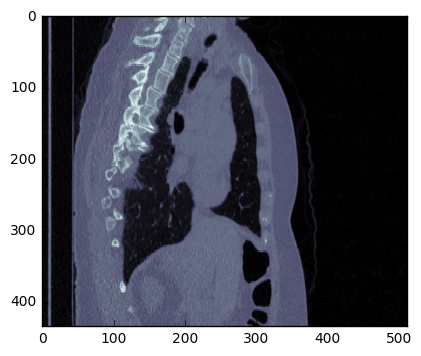

In [167]:
slice = slices[:,:,220]
print(slice.shape)
slice = transform.rotate(slice, 180)
plt.imshow(slice, cmap=plt.cm.bone)


step: 25.0


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


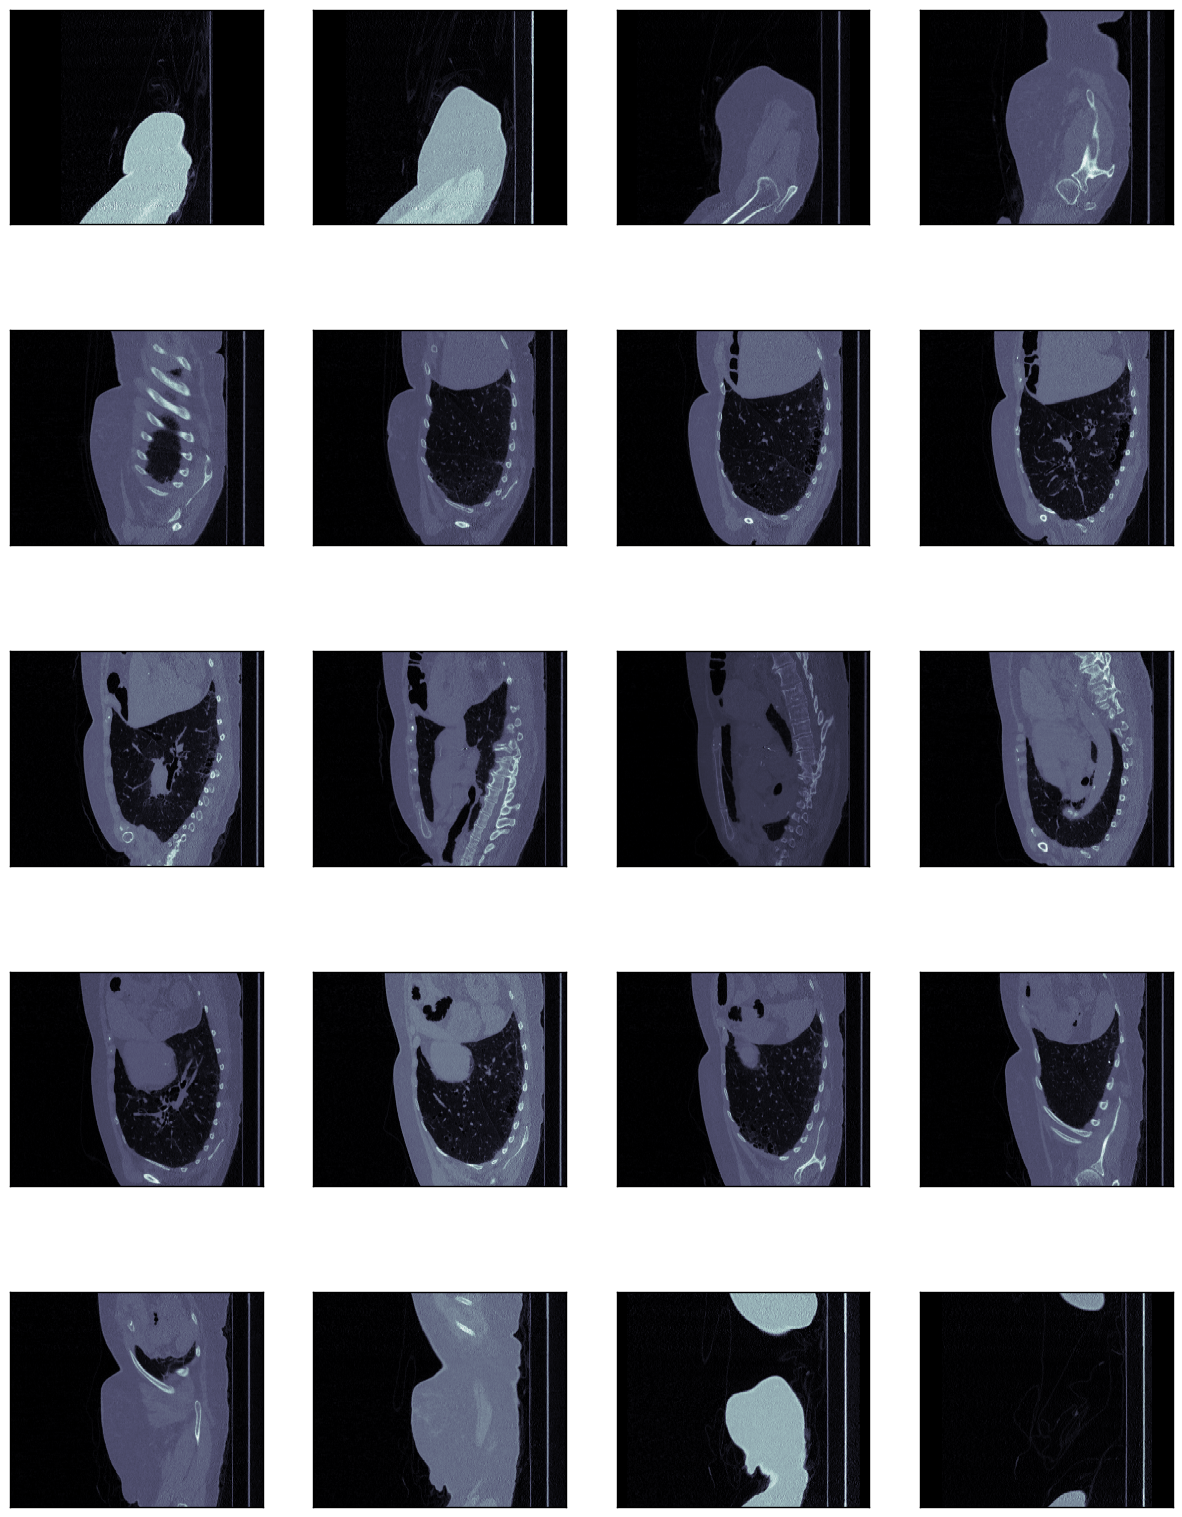

In [133]:
print()

plt.figure(figsize=(15,20))

rows = 5
cols = 4
step = 500 / (rows * cols)
print('step: ' + str(step))
for i in range(rows * cols):
     # cut at one of the axis
    plt.subplot(rows,cols,i+1)
    
    slice = slices[:, :, step*i]
    # slice[slice < -500] = -1024
    # slice[slice > -300] = -2000

    plt.imshow(slice, cmap=plt.cm.bone)

    plt.xticks([])
    plt.yticks([])


In [5]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (113, 512, 512)
Shape after resampling	 (282, 308, 308)


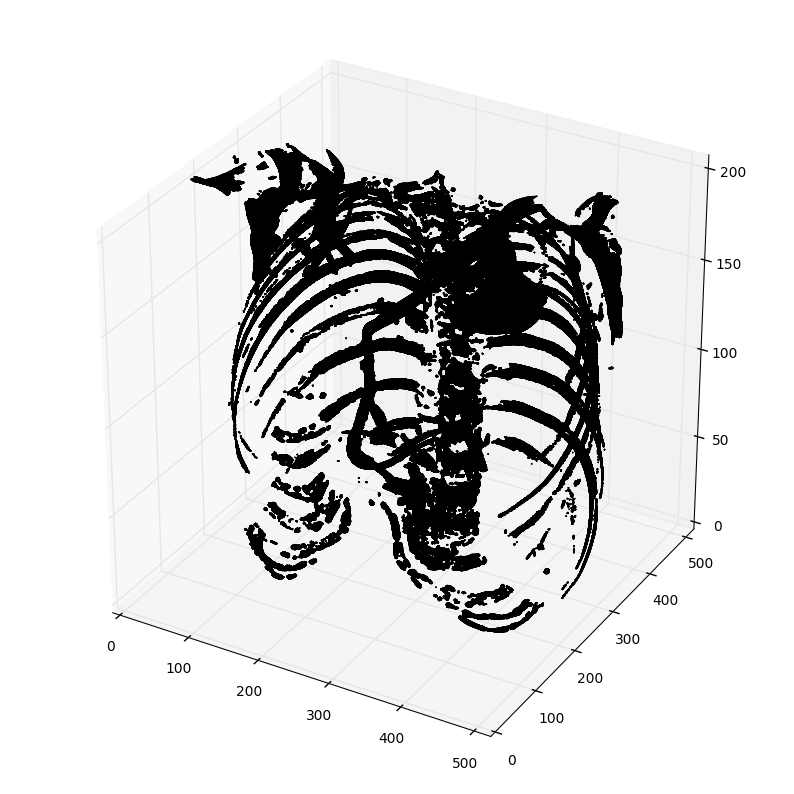

In [116]:
plot_3d(slices, 700)

In [ ]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(slices[0], slices[1], slices[2])
threedee.set_xlabel('Index')
threedee.set_ylabel('H-L')
threedee.set_zlabel('Volume')
plt.show()

# Submission

In [9]:
import time
sample = pd.read_csv(INPUT_FOLDER + '/stage2_sample_submission.csv')
print(sample.shape)

cancer = np.random.rand(sample.shape[0])

submission = pd.DataFrame(columns=['id', 'cancer'])
submission.id = sample.id
submission.cancer = cancer
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(506, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
id        506 non-null object
cancer    506 non-null float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


# References:
* https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial/run/928737
* https://www.kaggle.com/apapiu/data-science-bowl-2017/exploratory-analysis-visualization/notebook
* https://www.kaggle.com/mumech/data-science-bowl-2017/loading-and-processing-the-sample-images
* https://www.kaggle.com/armamut/data-science-bowl-2017/getting-the-lungs-right/notebook

* https://www.kaggle.com/olegtrott/data-science-bowl-2017/the-perfect-score-script/notebook
* https://www.kaggle.com/c/data-science-bowl-2017/discussion/29319